# Decision Trees & Ensemble Methods 

This notebook focuses on:
- model training and **cross-validation**,
- **Decision Trees** (classification & regression),
- ensemble methods: **Bagging**, **Random Forests**, **AdaBoost**.

**Learning goals**
- Understand K-fold cross-validation and hyperparameter tuning.
- Train and interpret Decision Trees for classification and regression.
- Apply and compare ensembles for improved performance.
- Practice with small synthetic supply-chain examples (late delivery classification, lead-time forecasting).

---

**Notebook structure**
1. Quick refresher: decision trees (concepts & hyperparameters)  
2. Cross-validation: why and how (practical)  
3. Classification example — will delivery be late? (synthetic supply-chain dataset)  
4. Regression example — lead time forecasting (synthetic)  
5. Ensembles: Bagging / Random Forests / AdaBoost  
6. Practical exercises and quiz (novice friendly)


**TODO : rendre le code plus intuitif en y incluant les éléments de cours pour les étudiants avec des exemples éventuellement comme cela a été fait pendant le cours pour illustrer les différents métriques : calcul de l'indice de Gini et du gain associé aux différentes règles en prenant un exemple en 2D avec peu de points. Il faudra faire de même pour la classificatin et revoir un peu l'enchaîment des chuncks de code pour rendre la lecture plus fluide. Prévoir aussi quelques explications sur le calcul de l'importance des variables et des remarques sur l'interpétabilité et l'explicabilité des modèles**




## I. What is a Decision Tree?

A Decision Tree splits the feature space into regions using simple rules like if/else rules, we talk about binary decision trees in this case. For **classification**, leaves predict class or labels of instances based on the most represented group in a leaf.
For **regression**, leaves return a numeric value (e.g. mean value of all instances in a leaf).
Depending on the type fo tree you aim to build, the metric you are goinfg to optimize is different. In classifcation tasks, you use the entropy or Gini index. In regression, you will learn the different rules using the variance.


- Advantages of decision trees: interpretable, handles mixed features, little preprocessing.
- Disadvantages of this model : can overfit (high variance), unstable small data changes.

**Key hyperparameters**

The following criterion are most common hyper-parameters of decision trees that benefit tuned during the learning stage. 

- `max_depth`: maximum depth of the tree (controls complexity).
- `min_samples_split`: minimum number of samples required to split an internal node.
- `min_samples_leaf`: minimum samples required to be at a leaf node.
- `criterion`: splitting criterion (`gini`, `entropy` for classification; `mse`/`friedman_mse` for regression).

  



Let us first have a look at the decision boundaries of a decision tree wigh respect to the choice of the hyperparameter `max_depth on the following simulated data.

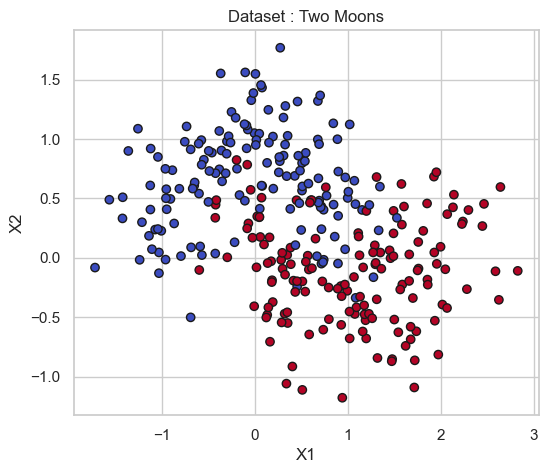

In [29]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

X, y = make_moons(noise=0.3, random_state=42, n_samples=300)

plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm', edgecolor='k')
plt.title("Dataset : Two Moons")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

$$  $$

**Question 1** : Run the following code and observe the performances of the decision tree. What can you say, in your opinion about the depth of the tree regarding the performances?

$$  $$

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = DecisionTreeClassifier(random_state=42, max_depth=2)
clf.fit(X_train, y_train)

print("Accuracy score on the test set :", accuracy_score(y_test, clf.predict(X_test)))

Accuracy score on the test set : 0.9


$$ $$

**Question 2** : Plot the decision tree using the following `plot_tree(clf, filled=True)`. What can you say about the structure?

$$ $$

[Text(0.5, 0.8333333333333334, 'x[1] <= 0.403\ngini = 0.498\nsamples = 210\nvalue = [112, 98]'),
 Text(0.25, 0.5, 'x[0] <= -0.497\ngini = 0.373\nsamples = 113\nvalue = [28, 85]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.117\nsamples = 16\nvalue = [15, 1]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.232\nsamples = 97\nvalue = [13, 84]'),
 Text(0.75, 0.5, 'x[0] <= 1.418\ngini = 0.232\nsamples = 97\nvalue = [84, 13]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.159\nsamples = 92\nvalue = [84, 8]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.0\nsamples = 5\nvalue = [0, 5]')]

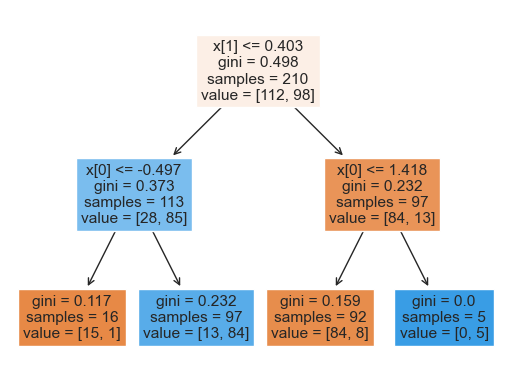

In [31]:
plot_tree(clf, filled=True)

We can also represent the decision boundaries using the following code. 

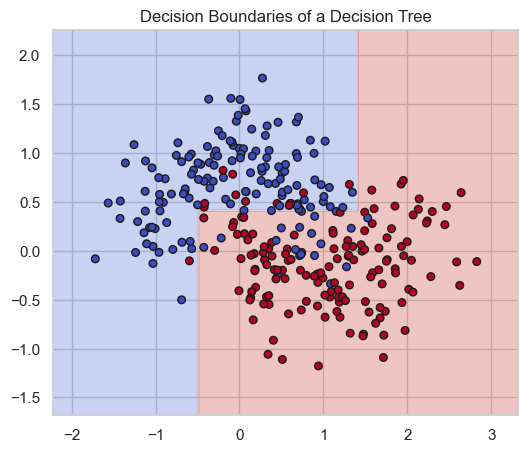

In [32]:
import numpy as np

def plot_decision_boundary(model, X, y, ax=None, title=None):
    if ax is None:
        ax = plt.gca()
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.3)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k', s=30)
    if title:
        ax.set_title(title)

# Example : 
fig, ax = plt.subplots(figsize=(6,5))
plot_decision_boundary(clf, X, y, ax, "Decision Boundaries of a Decision Tree")
plt.show()

$$ $$

**Question 3** : What can you say about the Decision Boundaries, is it consistent with the assumption formulated at Question 1?

$$ $$

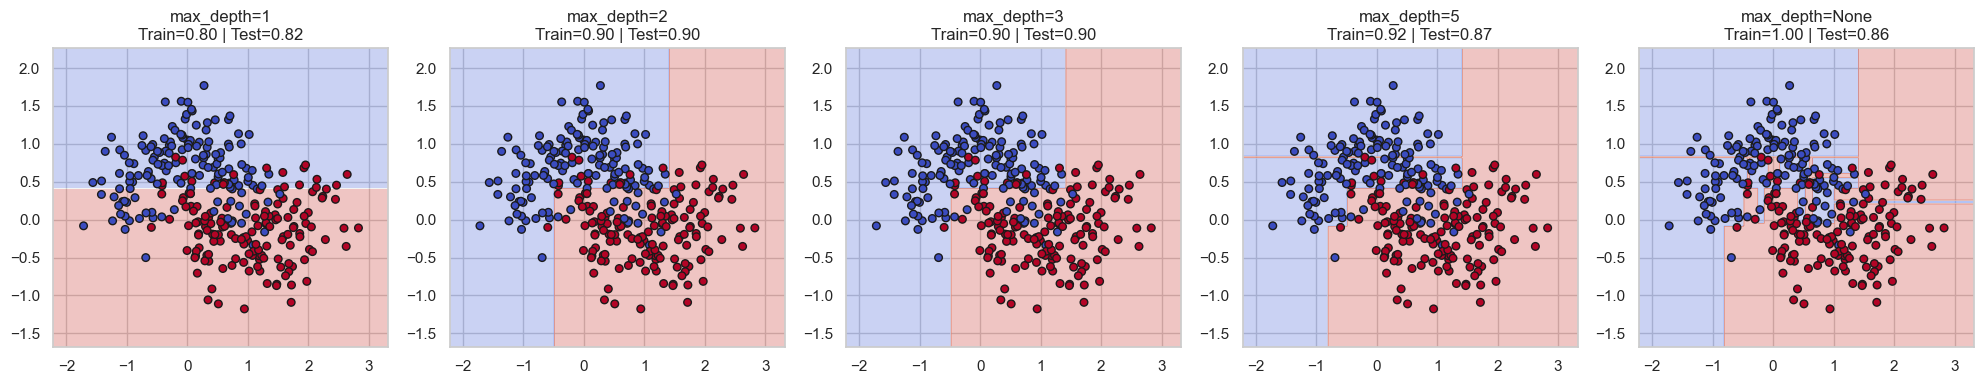

In [33]:
depth_values = [1, 2, 3, 5, None]

fig, axes = plt.subplots(1, len(depth_values), figsize=(20, 4))

for ax, d in zip(axes, depth_values):
    model = DecisionTreeClassifier(max_depth=d, random_state=42)
    model.fit(X_train, y_train)
    
    # Performances
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    
    # Graphs with scores
    title = f"max_depth={d}\nTrain={train_acc:.2f} | Test={test_acc:.2f}"
    
    plot_decision_boundary(model, X, y, ax, title=title)

plt.tight_layout()
plt.show()

$$ $$

**Question 4**: What do you notice about the train and test scores as the depth increases?

$$ $$

**Question 5**: What is the optimal structure in terms of depth according to the results obtained?

$$ $$

**Question 6**: Why does the tree with `max_depth=None` often have very good performance on the training set but poor performance on the test set?

$$ $$


We now want to study the influence of other hyperparameters on the model's performance. More specifically, we aim to examine the effects of the following hyperparameters:

* `min_samples_split`: minimum number of samples required to split a node
* `min_samples_leaf`: minimum number of samples required to be at a leaf node

For this, we will use the code below and fix the tree depth to $5$.


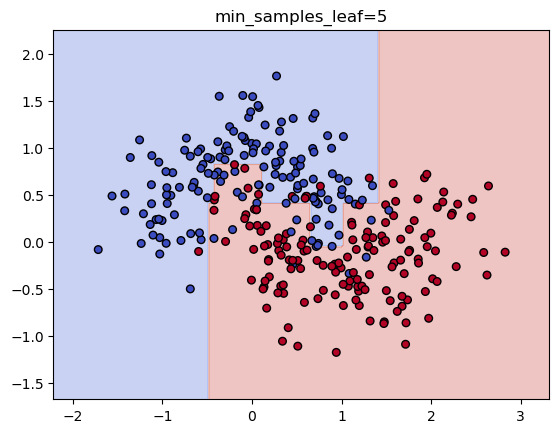

In [6]:
clf = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=42)
clf.fit(X_train, y_train)
plot_decision_boundary(clf, X, y, title="min_samples_leaf=5")

$$ $$

**Question 7**: Use the previous code to illustrate the impact of these two hyperparameters and study their effect.

$$ $$

**Question 8**: Compare the decision boundaries with `min_samples_leaf=1` and `min_samples_leaf=10`.

$$ $$

**Question 9**: What is the influence of `min_samples_split`?

$$ $$

## II.  Cross-validation

**Why use CV?**

A single train/test split can give misleading performance estimates due to random sampling. A K-fold CV provides a more reliable estimate of generalization by averaging performance across K splits and can be used for hyper-parameter tuning.

**Common approaches**

Several type of Cross-validation can be used, we present thme for the sake of completeness but the last one corresponds to the one presented in class. 

- K-Fold CV: split data into K parts; rotate which part is the validation set.
- Stratified K-Fold: preserves class proportions for classification (recommended if classes are imbalanced for instance).
- GridSearchCV: runs CV while searching over hyperparameter combinations.

**Practical tips for Supply Chain**

Use stratified CV if predicting binary outcomes like 'late' vs 'on-time', however, for time dependent data (lead times over time), use time-aware validation (not covered in depth here).


In [7]:
# Standard imports and helper functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
np.random.seed(0)

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score

def show_confusion(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()


## III. Decision Tree for a Classification Task

**Scenario:** 

Predict if a delivery will be **late** (1) or **on-time** (0) using features available before shipment:

- `distance_km` — distance to destination
- `order_size` — number of items in the order
- `hub_load` — load index at the origin hub
- `supplier_reliability` — historical reliability score (0 to 1)

We build a synthetic dataset to train a Decision Tree and evaluate via cross-validation and a test split.

The code below will not print anything, it is just used to generate some data and introduce a fucntion that will be used to show the results. 


In [8]:
from sklearn.datasets import make_classification

# Synthetic dataset that mimics supply chain factors
n = 600
X, y = make_classification(
    n_samples=n, n_features=4, n_informative=3, n_redundant=0,
    n_clusters_per_class=1, weights=[0.7, 0.3], class_sep=1.0, random_state=42
)

df = pd.DataFrame(X, columns=['distance_km', 'order_size', 'hub_load', 'supplier_reliability'])

# Transform features to realistic ranges for interpretation
df['distance_km'] = np.round((df['distance_km'] - df['distance_km'].min()) /
                             (df['distance_km'].max() - df['distance_km'].min()) * 500, 1)
df['order_size'] = np.round((df['order_size'] - df['order_size'].min()) /
                            (df['order_size'].max() - df['order_size'].min()) * 100).astype(int)
df['hub_load'] = np.clip((df['hub_load'] - df['hub_load'].min()) /
                         (df['hub_load'].max() - df['hub_load'].min()) * 10, 0, 10).round(2)
df['supplier_reliability'] = np.clip((df['supplier_reliability'] - df['supplier_reliability'].min()) /
                                     (df['supplier_reliability'].max() - df['supplier_reliability'].min()), 0, 1).round(2)
df['late'] = y

# Show the first rows
df.head()


,distance_km,order_size,hub_load,supplier_reliability,late
0,149.2,38,3.07,0.44,0
1,126.4,48,6.63,0.38,0
2,147.9,33,3.67,0.43,0
3,208.0,41,6.05,0.58,0
4,203.7,44,5.74,0.63,0


Accuracy (baseline tree): 0.88

Classification report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91       104
           1       0.79      0.83      0.81        46

    accuracy                           0.88       150
   macro avg       0.86      0.86      0.86       150
weighted avg       0.88      0.88      0.88       150



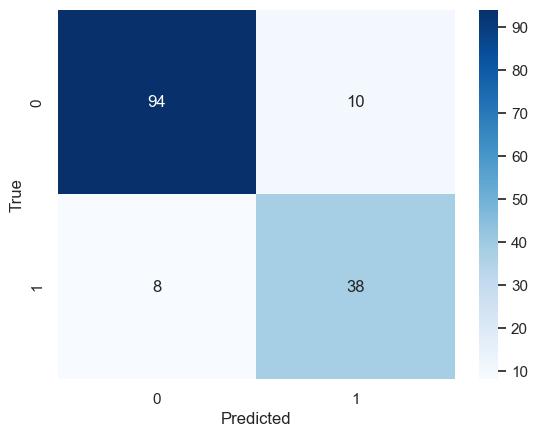

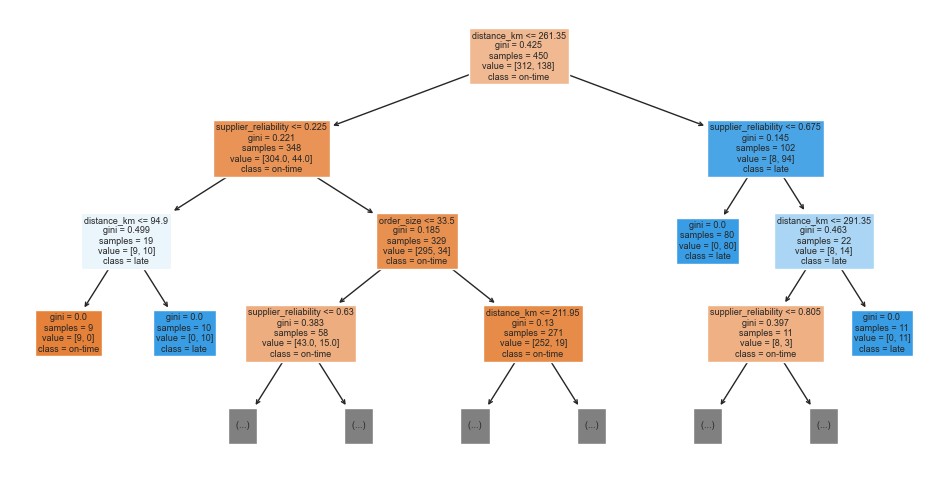

In [9]:
# Train/test split
X = df[['distance_km', 'order_size', 'hub_load', 'supplier_reliability']]
y = df['late']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

# Baseline Decision Tree
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

print('Accuracy (baseline tree):', round(accuracy_score(y_test, y_pred), 3))
print('\nClassification report:\n', classification_report(y_test, y_pred))
show_confusion(y_test, y_pred, labels=[0,1])

# Visualize a shallow tree (for readability, show top levels)
plt.figure(figsize=(12,6))
plot_tree(dt, feature_names=X.columns, class_names=['on-time', 'late'], filled=True, max_depth=3)
plt.show()


$$ $$

**Question 10 :** Describe the performances of this model.

$$ $$

### Hyperparameter tuning with GridSearchCV

We tune `max_depth` and `min_samples_leaf` using stratified 5-fold CV to find a tree with better generalization.



Best params: {'max_depth': 6, 'min_samples_leaf': 5}
Best CV accuracy: 0.9
Test accuracy (best estimator): 0.907


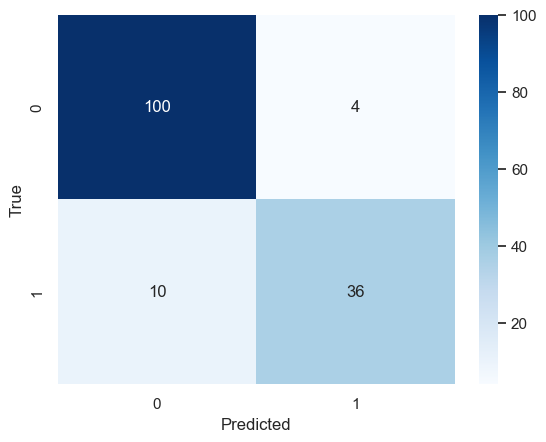

In [10]:
param_grid = {
    'max_depth': [2, 3, 4, 6, None],
    'min_samples_leaf': [1, 2, 5, 10]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gs = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid, scoring='accuracy', cv=cv, n_jobs=-1)
gs.fit(X_train, y_train)

print('Best params:', gs.best_params_)
print('Best CV accuracy:', round(gs.best_score_, 3))

best_dt = gs.best_estimator_
y_pred_gs = best_dt.predict(X_test)
print('Test accuracy (best estimator):', round(accuracy_score(y_test, y_pred_gs), 3))
show_confusion(y_test, y_pred_gs, labels=[0,1])


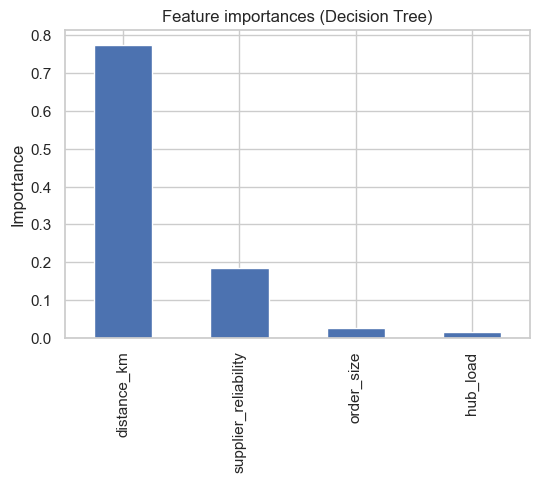

distance_km             0.775398
supplier_reliability    0.183913
order_size              0.025570
hub_load                0.015119
dtype: float64


In [11]:
# Feature importance for the best decision tree

fi = pd.Series(best_dt.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(6,4))
fi.plot(kind='bar')
plt.title('Feature importances (Decision Tree)')
plt.ylabel('Importance')
plt.show()

print(fi)


$$ $$

**Question 11 :** What is the most important variable?

$$ $$

## IV. Regression Trees

We now aim to illustrate how a regression tree works.  

### A. Illustration on a toy example 

For this, we will consider the dataset below, which follows a sinusoidal pattern. In the following, we will focus only on the parameter that controls the depth of the tree.

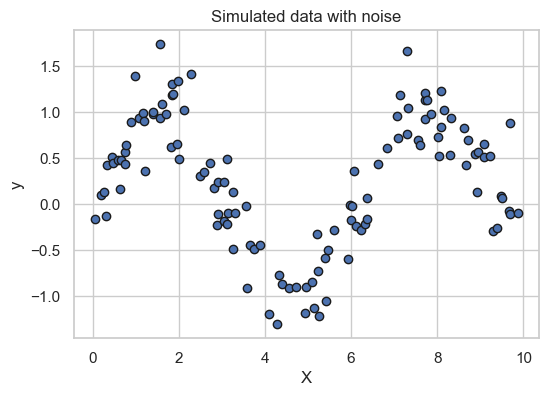

In [12]:
rng = np.random.RandomState(42)
X = np.sort(10 * rng.rand(120, 1), axis=0)
y = np.sin(X).ravel() + 0.3 * rng.randn(120)

plt.figure(figsize=(6,4))
plt.scatter(X, y, edgecolor='k')
plt.title("Simulated data with noise")
plt.xlabel("X")
plt.ylabel("y")
plt.show()

We will use the code below to study the impact of tree depth on model performance


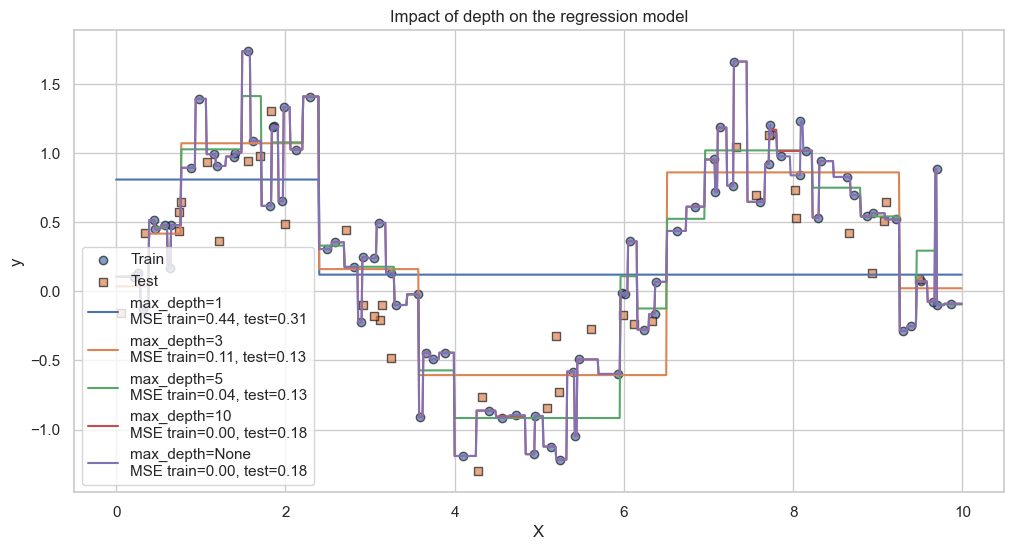

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

depths = [1, 3, 5, 10, None]
X_plot = np.arange(0.0, 10.0, 0.01)[:, np.newaxis]

plt.figure(figsize=(12, 6))
plt.scatter(X_train, y_train, edgecolor='k', label="Train", alpha=0.7)
plt.scatter(X_test, y_test, edgecolor='k', label="Test", alpha=0.7, marker='s')

for d in depths:
    reg = DecisionTreeRegressor(max_depth=d, random_state=42)
    reg.fit(X_train, y_train)
    
    # Predictions
    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)
    y_pred_plot = reg.predict(X_plot)
    
    # Errors
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    
    # Models and scores graphs
    plt.plot(X_plot, y_pred_plot, label=f"max_depth={d}\nMSE train={mse_train:.2f}, test={mse_test:.2f}")

plt.legend()
plt.title("Impact of depth on the regression model")
plt.xlabel("X")
plt.ylabel("y")
plt.show()

$$ $$

**Question 12**: What do you notice about the evolution of MSE_train and MSE_test as max_depth increases?

$$ $$

**Question 13**: Which depth seems most suitable for the bias/variance trade-off?

$$ $$

**Question 14**: What happens if we leave max_depth=None (unlimited tree)?
$$ $$


### B.. A Regression Tree for Lead time forecasting

**Scenario:** 

Predict delivery lead time (days) using:

- `distance_km`, `order_size`, `hub_load`, `supplier_reliability`
- `seasonality_index` (e.g., peak season increases lead time)

We create a simple synthetic regression dataset, train a Decision Tree Regressor, and evaluate with RMSE and R² as it was done in the linear regression model.

The code below is used to generate a synthetic dataset that will be used for the illustration.


In [14]:
# Synthetic regression dataset for lead times
n = 600
rng = np.random.RandomState(1)
distance = rng.uniform(10, 800, size=n)
order_size = rng.poisson(20, size=n)
hub_load = rng.uniform(0, 10, size=n)
supplier_reliability = rng.uniform(0.6, 1.0, size=n)
seasonality_index = rng.choice([0.8, 1.0, 1.2], size=n, p=[0.3, 0.4, 0.3])

# Simple generative model for lead time (days)
lead_time = 1 + 0.01 * distance + 0.05 * order_size + 0.2 * hub_load \
            - 2.0 * supplier_reliability + 1.5 * (seasonality_index - 1.0) \
            + rng.normal(scale=2.0, size=n)
lead_time = np.clip(lead_time, 0.5, None)

df_reg = pd.DataFrame({
    'distance_km': np.round(distance,1),
    'order_size': order_size,
    'hub_load': np.round(hub_load,2),
    'supplier_reliability': np.round(supplier_reliability,2),
    'seasonality_index': seasonality_index,
    'lead_time': np.round(lead_time,2)
})
df_reg.head()


,distance_km,order_size,hub_load,supplier_reliability,seasonality_index,lead_time
0,339.4,22,4.72,0.75,1.0,6.08
1,579.1,12,9.82,0.95,1.0,8.55
2,10.1,16,1.33,0.89,1.0,0.50
3,248.8,23,2.83,0.98,0.8,5.36
4,125.9,17,8.01,0.74,0.8,5.69


We repeat exactly the same steps as for the Classification Tree to study the performances of the Regression Tree. 

RMSE (baseline tree): 2.124
R2: 0.552


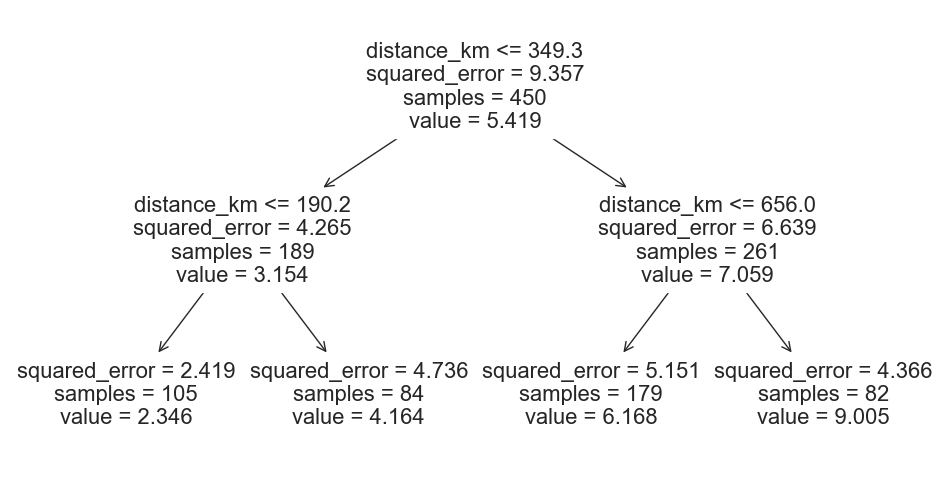

In [27]:
from sklearn.metrics import root_mean_squared_error

# Train/test split
Xr = df_reg.drop(columns=['lead_time'])
yr = df_reg['lead_time']

Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.25, random_state=0)

dtr = DecisionTreeRegressor(random_state=0, max_depth = 2)
dtr.fit(Xr_train, yr_train)
yr_pred = dtr.predict(Xr_test)

print('RMSE (baseline tree):', round(root_mean_squared_error(yr_test, yr_pred), 3))
print('R2:', round(r2_score(yr_test, yr_pred), 3))

plt.figure(figsize=(12,6))
plot_tree(dtr, feature_names=Xr.columns, rounded=True, max_depth=3)
plt.show()


We also go one with the cross-validaton procedure to optimize the hyperparameters.

In [28]:
param_grid_r = {'max_depth': [2, 3, 4, 6, None], 'min_samples_leaf': [1, 2, 5, 10]}
cv_r = KFold(n_splits=5, shuffle=True, random_state=0)

gsr = GridSearchCV(DecisionTreeRegressor(random_state=0), param_grid_r,
                   scoring='neg_mean_squared_error', cv=cv_r, n_jobs=-1)
gsr.fit(Xr_train, yr_train)

print('Best params (reg):', gsr.best_params_)
best_dtr = gsr.best_estimator_
yr_pred_gs = best_dtr.predict(Xr_test)

print('Test RMSE (best reg tree):', round(root_mean_squared_error(yr_test, yr_pred_gs), 3))
print('Test R2:', round(r2_score(yr_test, yr_pred_gs), 3))


Best params (reg): {'max_depth': 4, 'min_samples_leaf': 10}
Test RMSE (best reg tree): 2.053
Test R2: 0.581


$$ $$

**Question 15 :** Which variable has the most importance? Use the same code as for classification tree to answer this question.

$$ $$

## V. Ensemble Methods

Ensemble methods are techniques that involve combining multiple models to generate a new model that is potentially more *performant* but also more *robust*.  
This combination is generally done in two ways:

* via **bagging**
* or via **boosting**

The first approach, *i.e.*, bagging, helps reduce *variance*, making the model more robust while preserving its performance. The second approach, *i.e.*, boosting, helps reduce the component of error known as bias, making models more performant while maintaining their robustness.

We could also study another ensemble approach called **stacking**.  
While bagging and boosting combine multiple models of the same type, *i.e.*, several SVMs or several shallow trees, stacking involves combining multiple models of different types.


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.datasets import make_regression, make_moons
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import seaborn as sns

sns.set(style="whitegrid")

## A. Bagging: Variance Reduction

A flagship algorithm based on bagging is the random forest.  
In a few words, bagging methods consist of combining models that are learned from different information, *i.e.* from different samples.  
These models are then combined, usually by averaging, to create a single high-performing model.

We consider a training sample $S$ and perform the following procedure $T$ times, where $T$ represents the number of models we want to learn:  
(i) draw a sample $S_t$ with replacement from $S$,  
(ii) train a model $h_t$ using the sample $S_t$.

Once the $T$ models are learned, we obtain a global model $H_T$ that can be written as:

$$ H_T = \dfrac{1}{T}\sum_{t=1}^T h_t. $$

The simplest example is the combination of trees to build a *random forest* [Breiman, 2001].

Before combining the models, we will briefly review decision trees and then look to combine models.  
Consider the dataset below.


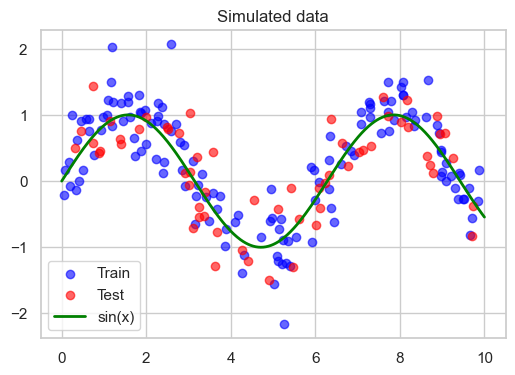

In [18]:
# Wavelets
rng = np.random.RandomState(42)
X = np.sort(10 * rng.rand(200, 1), axis=0)
y = np.sin(X).ravel() + 0.4 * rng.randn(200)
y_true = np.sin(np.linspace(0, 10, 500).reshape(-1, 1)).ravel()  # vraie fonction

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_plot = np.linspace(0, 10, 500).reshape(-1, 1)
plt.figure(figsize=(6,4))
plt.scatter(X_train, y_train, label="Train", color="blue", alpha=0.6)
plt.scatter(X_test, y_test, label="Test", color="red", alpha=0.6)
plt.plot(X_plot, y_true, color="green", linewidth=2, label="sin(x)")
plt.legend()
plt.title("Simulated data")
plt.show()

We will now look at the predictions made by a regression tree of depth $10$.  
Note that we could also do this with any other model, such as a high-degree polynomial linear regression, if we wanted.


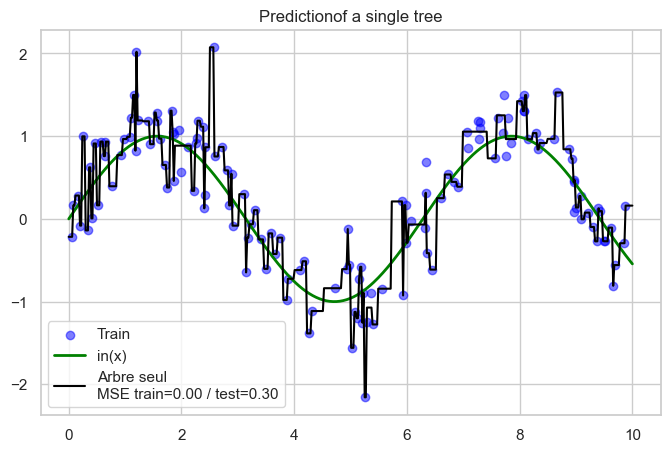

In [19]:
tree = DecisionTreeRegressor(max_depth=10, random_state=42)
tree.fit(X_train, y_train)

y_pred_train = tree.predict(X_train)
y_pred_test = tree.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

X_plot = np.linspace(0, 10, 500).reshape(-1, 1)
y_plot = tree.predict(X_plot)

plt.figure(figsize=(8,5))
plt.scatter(X_train, y_train, label="Train", color="blue", alpha=0.5)
plt.plot(X_plot, y_true, color="green", linewidth=2, label="in(x)")
plt.plot(X_plot, y_plot, label=f"Arbre seul\nMSE train={mse_train:.2f} / test={mse_test:.2f}", color="black")
plt.legend()
plt.title("Predictionof a single tree")
plt.show()

$$ $$

**Question 16**: Compare the prediction function to the true value. What do you observe?

$$ $$

**Question 17**: What happens if we increase the depth of the tree? Which error changes the most (train or test) as the complexity increases?

$$ $$

We will now focus on the bagging method, for which a direct implementation is proposed and illustrated below.


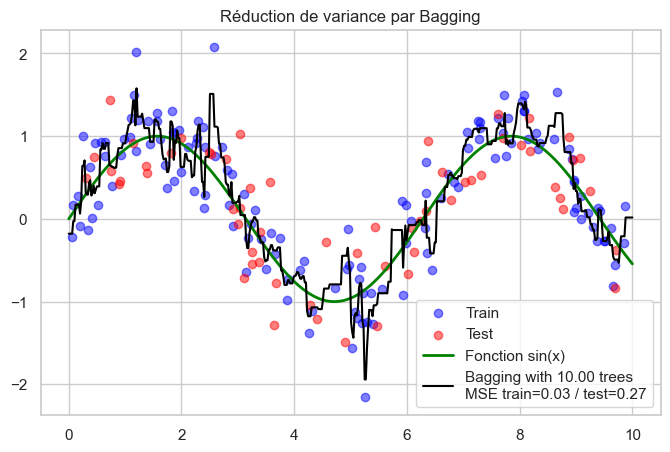

In [20]:
# Bagging with several trees 

n_trees = 10

bagging = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=10),
    n_estimators=n_trees,
    random_state=42,
    bootstrap=True
)
bagging.fit(X_train, y_train)

# Predictions
y_pred_train = bagging.predict(X_train)
y_pred_test = bagging.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

# Plots
plt.figure(figsize=(8,5))
plt.scatter(X_train, y_train, color="blue", alpha=0.5, label="Train")
plt.scatter(X_test, y_test, color="red", alpha=0.5, label="Test")
plt.plot(X_plot, y_true, color="green", linewidth=2, label="Fonction sin(x)")
plt.plot(X_plot, bagging.predict(X_plot), color="black",
         label=f"Bagging with {n_trees:.2f} trees \nMSE train={mse_train:.2f} / test={mse_test:.2f}")
plt.legend()
plt.title("Réduction de variance par Bagging")
plt.show()

$$ $$

**Question 18**: Compare the MSE between the single tree and the bagging model.

$$ $$

**Question 19**: What is the major difference you observe in the prediction curve?

$$ $$

**Question 20**: Explain why bagging reduces the variance of the model. For this, we will compare the error of the ensemble method to the average error of the individual predictors.

$$ $$

We now want to compare the behavior of different trees learned on bootstrap samples and our regressor obtained using the bagging method.  
We will therefore create different bootstrap samples as explained at the beginning of this section.  
As a reminder, a bootstrap sample $S_b$ is a sample of the same size as the original sample $S$, obtained by drawing with replacement from the examples in $S$.


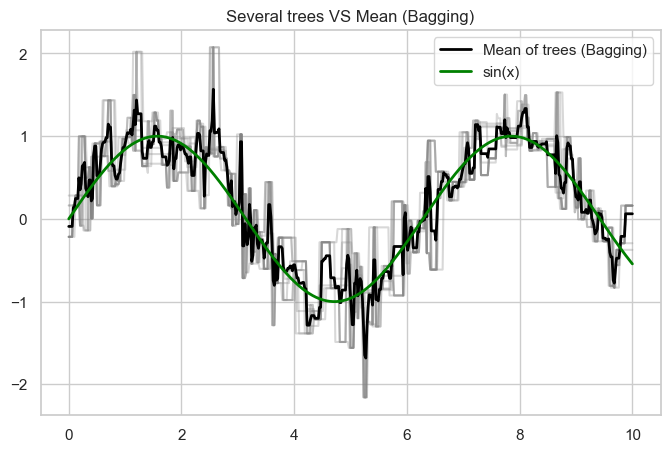

In [21]:
from sklearn.utils import resample

plt.figure(figsize=(8,5))

predictions = []

for i in range(10):
    # Boostrap Sampling
    X_boot, y_boot = resample(X, y, replace=True, random_state=i)
    
    # Learning Tree
    tree = DecisionTreeRegressor(max_depth=10)
    tree.fit(X_boot, y_boot)
    
    # Predictions
    y_pred = tree.predict(X_plot)
    predictions.append(y_pred)
    
    # Plots
    plt.plot(X_plot, y_pred, color="gray", alpha=0.3)

#plt.plot(X_plot, bagging.predict(X_plot), color="red", linewidth=2, label="Bagging (moyenne)")
y_mean = np.mean(predictions, axis=0)
plt.plot(X_plot, y_mean, color="black", linewidth=2, label="Mean of trees (Bagging)")
plt.plot(X_plot, y_true, color="green", linewidth=2, label="sin(x)")
plt.title("Several trees VS Mean (Bagging)")
plt.legend()
plt.show()

$$ $$

**Question 21**: What do you notice about the gray curves representing the predictions of the individual trees?

$$ $$

**Question 22**: Why are these trees different from each other?

$$ $$

**Question 23**: In what way is the average of the trees (curve shown in black) more stable?

$$ $$

**Question 24**: How does this average illustrate the variance reduction provided by bagging?

$$ $$

**Question 25**: Try modifying `n_estimators` and `max_depth` and observe how this affects the stability of the final model.

$$ $$


We now want to compare the performance of a decision tree with that of a random forest for a classification problem.


In [22]:
from sklearn.datasets import make_moons

X, y = make_moons(noise=0.4, random_state=42, n_samples=300)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree = DecisionTreeClassifier(max_depth=5, random_state=42)
forest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

tree.fit(X_train, y_train)
forest.fit(X_train, y_train)

acc_tree = accuracy_score(y_test, tree.predict(X_test))
acc_forest = accuracy_score(y_test, forest.predict(X_test))

print(f"Accuracy arbre : {acc_tree:.3f}")
print(f"Accuracy forêt : {acc_forest:.3f}")

Accuracy arbre : 0.822
Accuracy forêt : 0.856


$$ $$

**Question 26**: What performance difference do you observe?

$$ $$

**Question 27**: Why is the random forest more robust?

$$ $$

**Question 28**: What happens if we reduce `n_estimators`?

$$ $$


## B. Boosting: Bias Reduction

Previously, models were trained independently of each other. The idea of boosting is to break this independence.

We assume that the models learned have low predictive power, and we want to create a combination of these models so that the combined model performs better.  
To do this, we learn our models iteratively in such a way that the model learned at the current iteration can correct the errors made by the previous model.

The first boosting algorithm developed to address this problem is the *Adaboost* algorithm [Freund, 1999].

#### Principle of Boosting

Let’s now look at the different steps of an Adaboost algorithm.

We initially have our sample $S$ with $m$ examples $(x_i, y_i)$, and all data points have **the same weight**, i.e., the same importance.

We now consider how a hypothesis $h_{t+1}$ is learned based on the performance of the classifier $h_t$.  
At step $t$ of the algorithm, the examples have weights $w^{(t)}_i$.  
A hypothesis $h_t$ is then learned, and we can evaluate its classification error rate $\varepsilon_t$:

$$ \varepsilon_t = \sum_{i=1}^m w^{(t)}_i I_{\left\{ h_t(x_i)y_i <0\right\}}, $$

where $I$ denotes the indicator function. From this error, we determine a quantity $\alpha_t$ defined by:

$$ \alpha_t = \dfrac{1}{2}\ln \left(\dfrac{1-\varepsilon_t}{\varepsilon_t}\right), $$

which quantifies the importance of hypothesis $h_t$ in the final decision, i.e., it defines a weight on the learned classifier.

The rest of the procedure consists of finding **a good reweighting of the examples** so that the hypothesis learned at the next iteration focuses on the errors made by the current hypothesis. This is done using the following update:

$$ w^{(t+1)}_i = w^{(t)}_i\dfrac{\exp(-\alpha_ty_ih_t(x_i))}{Z_t}, $$

where $Z_t$ is a normalization factor ensuring that the weights form a distribution over the examples.  
Later, we will see that this normalization factor is given by $Z_t = 2\sqrt{\varepsilon_t(1-\varepsilon_t)}.$  
The reweighting function increases the weight of misclassified examples and decreases the weight of correctly classified examples.


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


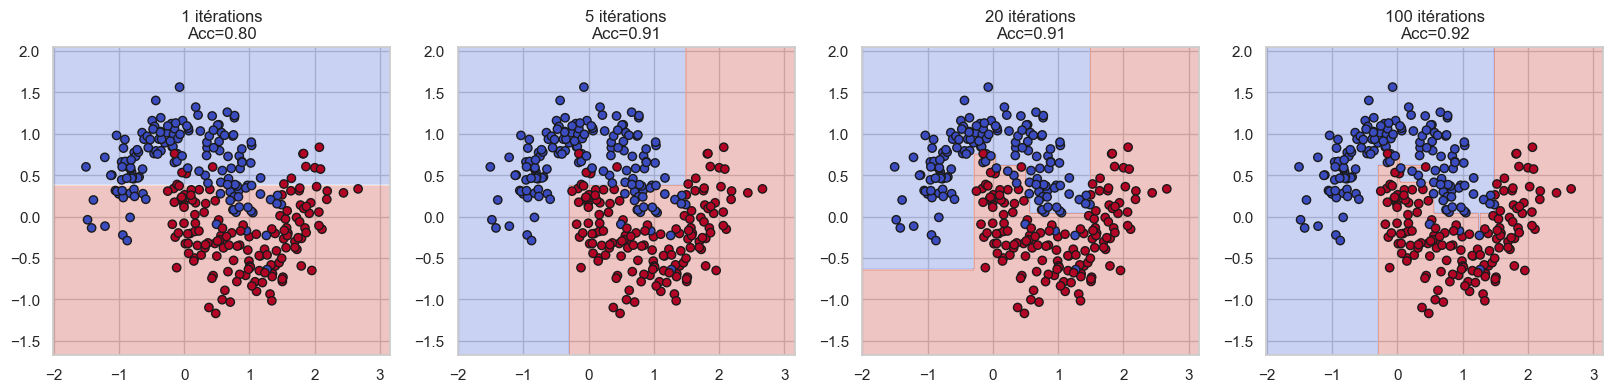

In [23]:
from sklearn.ensemble import AdaBoostClassifier

X, y = make_moons(noise=0.25, random_state=0, n_samples=300)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Visualize decision boundaries
def plot_decision_boundary(model, X, y, ax, title=None):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.3)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k')
    if title:
        ax.set_title(title)

# List of number of trees for visualization
n_estimators_list = [1, 5, 20, 100]

fig, axes = plt.subplots(1, len(n_estimators_list), figsize=(20,4))
for ax, n in zip(axes, n_estimators_list):
    ada = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=n,
        learning_rate=0.5,
        random_state=42
    )
    ada.fit(X_train, y_train)
    acc = accuracy_score(y_test, ada.predict(X_test))
    plot_decision_boundary(ada, X, y, ax, title=f"{n} itérations\nAcc={acc:.2f}")
plt.show()

$$ $$

**Question 29**: How does the decision boundary evolve with the number of iterations?

$$ $$

**Question 30**: What happens if the *learning_rate* is too high? Start by experimenting with this parameter and observe its impact on the decision boundaries to answer the question.

$$ $$

Recall that our ensemble model $H_T$ is the combination of several models $h_t$ that are learned iteratively.  
We have

$$H_T = \sum_{t=0}^T \alpha_t h_t$$

The *learning_rate* parameter actually multiplies the values of $\alpha_t$ such that $\alpha_t \leftarrow \alpha_t \times learning\_rate$.  
An illustration of the impact of this parameter on the model’s performance is shown below.


In [24]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X, y = make_moons(n_samples=300, noise=0.25, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Deux modèles avec learning_rate différents
ada1 = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=10,
    learning_rate=0.1,  # faible
    random_state=42
)
ada2 = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=10,
    learning_rate=1.0,  # standard
    random_state=42
)

ada1.fit(X_train, y_train)
ada2.fit(X_train, y_train)

print("Acc faible LR:", accuracy_score(y_test, ada1.predict(X_test)))
print("Acc LR=1 :", accuracy_score(y_test, ada2.predict(X_test)))

Acc faible LR: 0.8777777777777778
Acc LR=1 : 0.9111111111111111


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
